In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import safe as sf
import datamol as dm
from safe.trainer.data_utils import get_dataset
from safe.tokenizer import SAFETokenizer
from transformers import GenerationConfig


In [ ]:
fragments = 

In [5]:
model_path = "../../expts/model-v0/"
gen_config = GenerationConfig.from_pretrained(model_path)

In [6]:
model = sf.trainer.model.SAFEDoubleHeadsModel.from_pretrained(model_path)
_ = model.eval()

In [7]:
tokenizer = SAFETokenizer.load("../../expts/tokenizer/tokenizer-custom.json")
tokenizer_pretrained = tokenizer.get_pretrained()

In [8]:
data = get_dataset("../../expts/dev-data/", streaming=False, tokenize_column="input", property_column=None)
test_data = data["test"]

In [9]:
import torch
from transformers import set_seed

In [19]:
index = 102
frag = 1
with torch.no_grad():
    inputs = test_data["input"][index].split(".")[frag]
    encoded_text = tokenizer_pretrained(inputs, return_tensors="pt", add_special_tokens=True)
    #encoded_text.pop("token_type_ids")
    outputs = model.generate(**encoded_text, max_new_tokens=50, return_dict_in_generate=True, num_beams=1, output_scores=True, do_sample=True, num_return_sequences=3)

    sample = tokenizer_pretrained.batch_decode(outputs.sequences, skip_special_tokens=True)
sample

['N32/C=C(/C#N)C(O)=Nc1cccc(Cl)c1Cc1nnc(S(=O)[O-])s1.S3(=O)(=O)C(=O)[O-]',
 'N32/C=C(/C#N)C(O)=Nc1cccc(Cl)c1C[C@H]4[C@@H](O)CO.C4(=O)[O-].c13ccc(Cl)cc1',
 'N32/C=C(/C#N)C(O)=Nc1cccc(Cl)c1CC1CC1.C24.[C@@H]14CCCCO1']

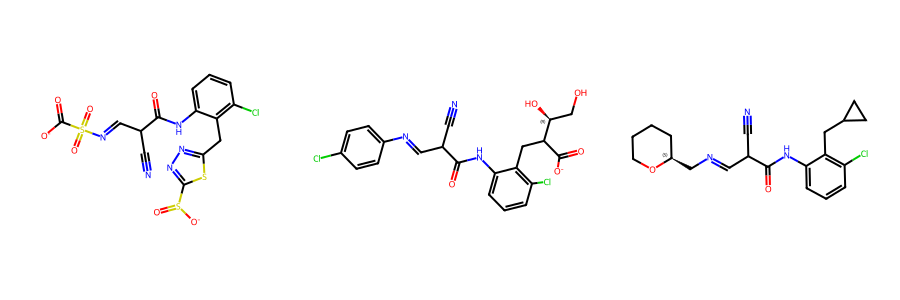

In [27]:
dm.to_image([sf.decode(x, remove_dummies=True, canonical=True, as_mol=True, ignore_errors=True) for x in sample])

In [171]:
transition_score = model.compute_transition_scores(outputs.sequences, outputs.scores, normalize_logits=True)

In [175]:
outputs.scores[0].shape

torch.Size([3, 1880])

['CC1Cc2ccccc2CN13.C3C4.c14nc2ccccc2[nH]1',
 'CC1Cc2ccccc2CN13.C34.C14CC2CCOC2C1',
 'CC1Cc2ccccc2CN13.C3CC4.c14ccc(S(=O)(=O)N=c2sc(N)cc25cc1O.C5(F)(F)F',
 'CC1Cc2ccccc2CN13.c13ccc(C(N)=S)cc1F']

In [311]:
decoded_sf = [sf.decode(x, remove_dummies=True, remove_added_hs=True, ignore_errors=True) for x in sample]

In [312]:
print(decoded_sf)
decoded_sf = [x for x in decoded_sf if x is not None]

['CC1Cc2ccccc2CN1CCc1nc2ccccc2[nH]1', 'CC1Cc2ccccc2CN1CC1CC2CCOC2C1', None, 'CC1Cc2ccccc2CN1c1ccc(C(N)=S)cc1F']


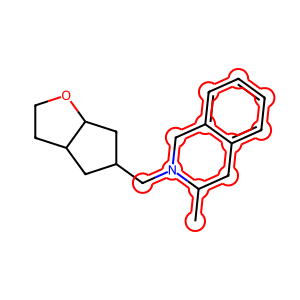

In [314]:
sf.to_image(decoded_sf[1], [sf.decode(inputs, remove_dummies=False)])

In [19]:
x = sf.decode("O=C3CC5", as_mol=False, remove_dummies=False)
m = dm.remove_hs(dm.to_mol(x), update_explicit_count=False, implicit_only=False)

In [145]:
gen_config.bos_token_id

1

In [9]:

from rdkit.Chem.rdmolops import ReplaceCore
from rdkit.Chem.rdmolops import AdjustQueryParameters
from rdkit.Chem.rdmolops import AdjustQueryProperties
def compute_side_chain(side_chains=None, mol=None, core=None):
    if side_chains is None:
        if mol is None and core is None:
            raise ValueError(
                "Either side_chains OR mol+core should be provided for scaffold morphing"
            )

        if isinstance(mol, str):
            mol = dm.to_mol(mol)
        if isinstance(core, str):
            core = dm.to_mol(core)
        core_query_param = AdjustQueryParameters()
        core_query_param.makeDummiesQueries = True
        core_query_param.adjustDegree = False
        core_query_param.aromatizeIfPossible = True
        core_query_param.makeBondsGeneric = False
        core_query = AdjustQueryProperties(core, core_query_param)
        #core_query = core
        side_chains = ReplaceCore(mol, core_query, labelByIndex=False,replaceDummies=False, requireDummyMatch=False)
    return side_chains
    

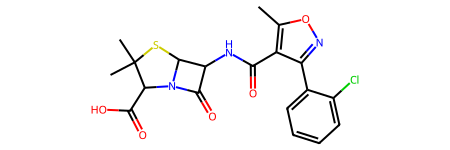

In [10]:
import datamol as dm
mol = "CC1=C(C(=NO1)C2=CC=CC=C2Cl)C(=O)NC3C4N(C3=O)C(C(S4)(C)C)C(=O)O"
dm.to_mol(mol)

In [15]:
core0 = "CC1(C)CN2C(CC2=O)S1"
core1 = "CC1N2C(SC1(C)C)C(N)C2=O"
core2 = "CC1(C)SC2C(-*)C(=O)N2C1-*"
core3 = "CC1(C)SC2C(-[*:1])C(=O)N2C1-[*:2]"
core4 = "CC1=C(C(=O)N-*)C(-*)=NO1"
core5 = "*-NC(=O)C1=CON=C1-*"

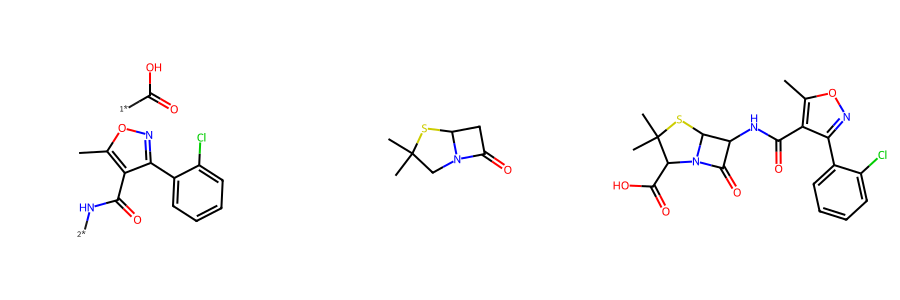

In [19]:
side_chain = compute_side_chain(core=core0, mol=mol)
dm.to_image([side_chain, core0, mol])

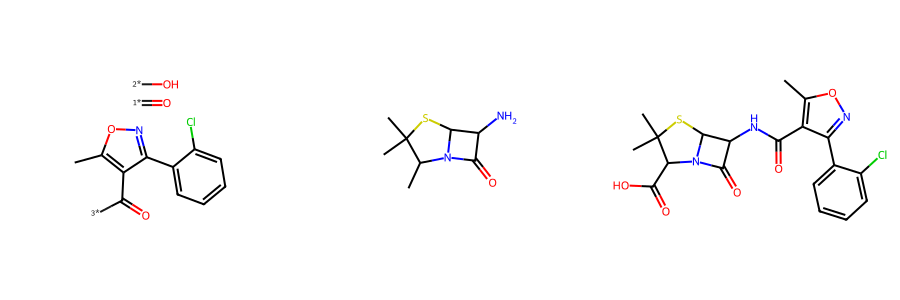

In [20]:
side_chain = compute_side_chain(core=core1, mol=mol)
dm.to_image([side_chain, core1, mol])

In [27]:
sf.encode(side_chain)

In [30]:
side_chains = sf.trainer.utils.compute_side_chains(core=core2, mol=mol)
if isinstance(side_chains, list):
    side_chains = [dm.to_mol(x) for x in side_chains]
else:
    side_chains = [dm.to_mol(side_chains)]
side_chains = ".".join([dm.to_smiles(x) for x in side_chains])

In [40]:

sf.encode(side_chains, randomize=True)

'C43=O.N44.c13c5noc1C.c15ccccc1Cl.C3(=O)O'

In [41]:
from rdkit.Chem import FragmentOnBonds

In [54]:
dm.to_smiles(dm.reactions.open_attach_points(dm.to_mol(core0)))

'*CC1(C*)SC2(*)C(*)C(=O)N2C1*'

In [49]:
import re
from rdkit import Chem
from rdkit.Chem import BondType


In [116]:
prods = sf.utils.list_individual_attach_points(dm.to_mol(core0), depth=3)

In [117]:
prods

['[*]CC1(C[*])CN2C(=O)CC2S1',
 '[*]C1C(=O)N2C1SC(C)(C)C2[*]',
 '[*]CC1(C[*])SC2CC(=O)N2C1[*]',
 '[*]CC1(C[*])CN2C(=O)CC2([*])S1',
 '[*]C1N2C(=O)CC2([*])SC1(C)C',
 '[*]CC1(C)CN2C(=O)C([*])C2S1',
 '[*]CC1(C)CN2C(=O)C([*])C2([*])S1',
 '[*]CC1(C)SC2CC(=O)N2C1[*]',
 '[*]CC1(C)SC2C([*])C(=O)N2C1[*]',
 '[*]C1N2C(=O)C([*])C2([*])SC1(C)C',
 '[*]CC1(C)CN2C(=O)CC2S1',
 '[*]CC1(C)SC2([*])CC(=O)N2C1[*]',
 '[*]C12CC(=O)N1CC(C)(C)S2',
 '[*]C1C(=O)N2CC(C)(C)SC12',
 '[*]CC1(C[*])CN2C(=O)C([*])C2S1',
 '[*]C1N2C(=O)CC2SC1(C)C',
 '[*]CC1(C)CN2C(=O)CC2([*])S1',
 '[*]C1C(=O)N2CC(C)(C)SC12[*]']

In [119]:
import random
rng = random.Random(10)
rng.shuffle(prods)